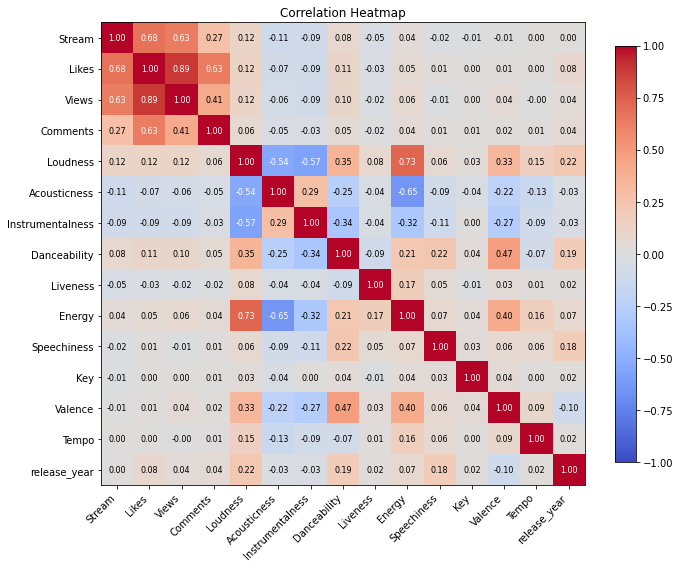

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

CSV = "clean_data.csv"
TARGET = "Stream"                 
MIN_NONNA_RATIO = 0.2             
SAVE_PATH = "corr_heatmap.png"                  

# 1) Load
df = pd.read_csv(CSV)

# 2) release_year from release_date / release_date_raw
def to_year(s):
    if pd.isna(s): return np.nan
    s = str(s)
    try:
        return int(s[:4])
    except Exception:
        return np.nan

if "release_date" in df.columns:
    df["release_year"] = df["release_date"].map(to_year)
elif "release_date_raw" in df.columns:
    df["release_year"] = df["release_date_raw"].map(to_year)

# 3) coerce booleans if present
for col in ["Licensed", "official_video"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.upper().map({"TRUE": 1, "FALSE": 0})
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 4) numeric candidates
cand_cols = [
    "Danceability","Energy","Key","Loudness","Speechiness","Acousticness",
    "Instrumentalness","Liveness","Valence","Tempo",
    "Views","Likes","Comments","Stream","release_year","Licensed","official_video"
]
num_cols = [c for c in cand_cols if c in df.columns]
num = df[num_cols].copy()

# 5) drop sparse or constant columns
keep = []
for c in num.columns:
    col = num[c]
    if col.notna().mean() < MIN_NONNA_RATIO:   # too sparse
        continue
    if col.nunique(dropna=True) <= 1:          # constant
        continue
    keep.append(c)
num = num[keep]

# If TARGET got dropped, fall back to the first numeric col
if TARGET not in num.columns:
    TARGET = num.columns[0]

# 6) correlation + reorder by |corr with TARGET|
corr = num.corr(method="pearson")
target_corr = corr[TARGET].abs().sort_values(ascending=False)
ordered_cols = [TARGET] + [c for c in target_corr.index if c != TARGET]
corr = corr.loc[ordered_cols, ordered_cols]

# 7) Plot with coolwarm centered at 0
fig, ax = plt.subplots(figsize=(10, 8))

# center colors at 0; symmetric limits based on max |corr|
max_abs = np.nanmax(np.abs(corr.values))
norm = TwoSlopeNorm(vcenter=0.0, vmin=-max_abs, vmax=max_abs)

im = ax.imshow(corr.values, cmap="coolwarm", norm=norm, aspect="auto")

cbar = fig.colorbar(im, ax=ax, shrink=0.9)

# ticks / labels
ax.set_xticks(range(len(ordered_cols)))
ax.set_yticks(range(len(ordered_cols)))
ax.set_xticklabels(ordered_cols, rotation=45, ha="right")
ax.set_yticklabels(ordered_cols)
ax.set_title("Correlation Heatmap".format(TARGET))

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        v = corr.iloc[i, j]
        txt = f"{v:.2f}" if pd.notna(v) else ""
        color = "white" if pd.notna(v) and abs(v) > 0.5 else "black"
        ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

fig.tight_layout()
if SAVE_PATH:
    plt.savefig(SAVE_PATH, dpi=200, bbox_inches="tight")
